In [1]:
!pip install pmdarima

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
Data = pd.read_csv(
    'full.csv', 
    index_col='Date', parse_dates=True
)

# Selected Important Columns From Dataset 
#'UNITS', 'DAILY_AQI_VALUE', 'Site Name', 'AQS_PARAMETER_DESC','COUNTY', 'SITE_LATITUDE', 'SITE_LONGITUDE
Data = Data[['UNITS', 'DAILY_AQI_VALUE', 'Site Name', 'AQS_PARAMETER_DESC','COUNTY', 'SITE_LATITUDE', 'SITE_LONGITUDE']]
Data.head(3)

,UNITS,DAILY_AQI_VALUE,Site Name,AQS_PARAMETER_DESC,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
Date,,,,,,,
2017-01-01,ppm,6.0,Azusa,Carbon monoxide,Los Angeles,34.1365,-117.92391
2017-01-02,ppm,5.0,Azusa,Carbon monoxide,Los Angeles,34.1365,-117.92391
2017-01-03,ppm,5.0,Azusa,Carbon monoxide,Los Angeles,34.1365,-117.92391


In [4]:
# Unique AQS_PARAMETER_DESC Values
set(Data['AQS_PARAMETER_DESC'])

{'Acceptable PM2.5 AQI & Speciation Mass',
 'Carbon monoxide',
 'Ozone',
 'PM10 Total 0-10um STP',
 'PM2.5 - Local Conditions'}

## Site Name: Azusa

In [5]:
# Unique Site Names Across Different Countries
Data['Site Name'].unique()

array(['Azusa', 'Glendora', 'West Los Angeles',
       'Los Angeles-North Main Street', 'Reseda', 'Compton',
       'Pico Rivera #2', 'Pomona', 'Pasadena', 'Long Beach (Hudson)',
       'LAX Hastings', 'Santa Clarita', 'Lancaster-Division Street',
       'Long Beach (South)', 'Long Beach (North)',
       'Long Beach-Route 710 Near Road', 'Lebec',
       'North Hollywood (NOHO)', 'Signal Hill (LBSH)', 'San Francisco',
       'Oakland', 'Oakland West', 'Laney College',
       'Berkeley- Aquatic Park', 'Pleasanton - Owens Ct', 'Livermore',
       'Hayward', 'Patterson Pass'], dtype=object)

In [6]:
# You can Change Site Name List Above to Predict the Future Forcasting 
Site_Name = 'Azusa'  

In [7]:
Azusa_DT = Data[Data['Site Name']==Site_Name]

Azusa_DT = Azusa_DT[Azusa_DT['AQS_PARAMETER_DESC']=='Ozone'] # Can Change the AQS_PARAMETER_DESC Value 
Azusa_DT.head()

,UNITS,DAILY_AQI_VALUE,Site Name,AQS_PARAMETER_DESC,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
Date,,,,,,,
2017-01-01,ppm,34.0,Azusa,Ozone,Los Angeles,34.1365,-117.92391
2017-01-02,ppm,35.0,Azusa,Ozone,Los Angeles,34.1365,-117.92391
2017-01-03,ppm,24.0,Azusa,Ozone,Los Angeles,34.1365,-117.92391
2017-01-04,ppm,19.0,Azusa,Ozone,Los Angeles,34.1365,-117.92391
2017-01-05,ppm,14.0,Azusa,Ozone,Los Angeles,34.1365,-117.92391


<AxesSubplot: xlabel='Date'>

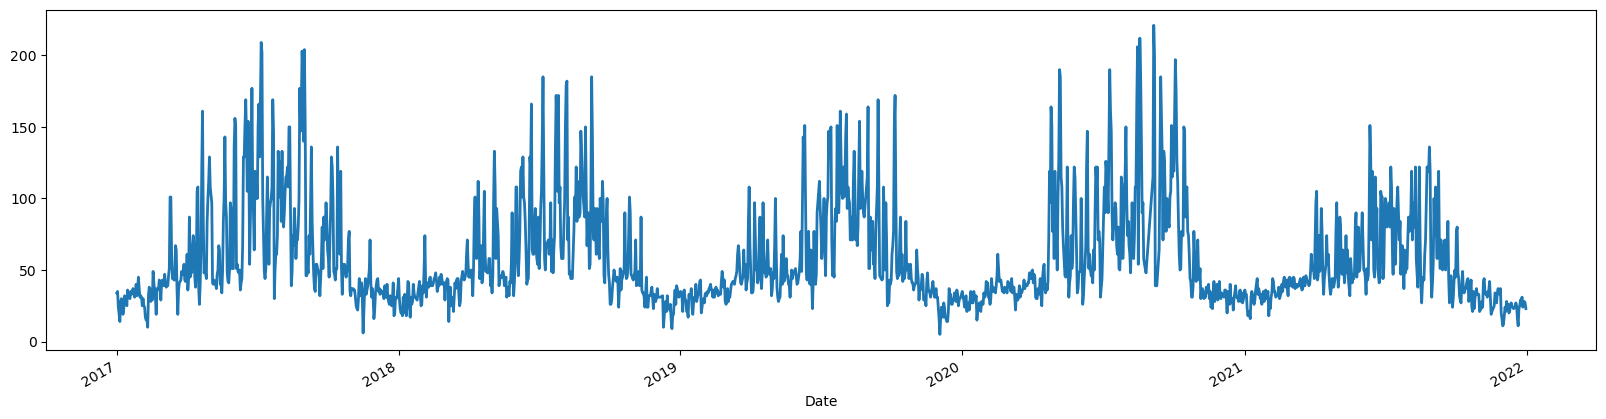

In [8]:
# Historical Data of Given Country
Azusa_DT.DAILY_AQI_VALUE.plot(figsize=(20, 5), linewidth=2)

<Figure size 640x480 with 0 Axes>

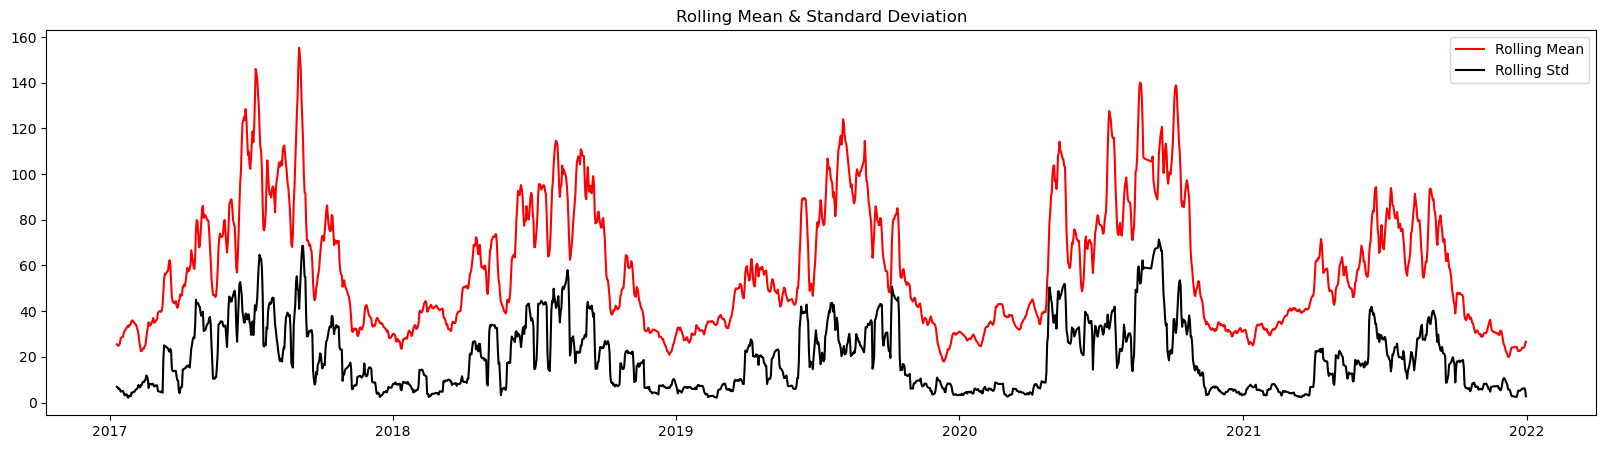

In [9]:
RollingMean = Azusa_DT['DAILY_AQI_VALUE'].rolling(10).mean()
RollingStd = Azusa_DT['DAILY_AQI_VALUE'].rolling(10).std()

fig = plt.figure(1)
plt.figure(figsize=(20,5))

mean = plt.plot(RollingMean, color='red', label='Rolling Mean')
std = plt.plot(RollingStd, color='black', label = 'Rolling Std')

plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [10]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [11]:
stepwise_fit = auto_arima(
    Azusa_DT['DAILY_AQI_VALUE'],
    suppress_warnings=True,
    seasonal=True
)           
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1771
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -7910.951
Date:                Sun, 05 Feb 2023   AIC                          15833.903
Time:                        21:19:05   BIC                          15866.778
Sample:                             0   HQIC                         15846.048
                               - 1771                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3385      0.231      1.466      0.143      -0.114       0.791
ar.L1          1.3756      0.034     40.771      0.000       1.309       1.442
ar.L2         -0.3817      0.033    -11.657      0.000      -0.446      -0.318
ma.L1         -0.6102      0.032    -18.868      0.000      -0.674      -0.547
ma.L2         -0.2854      0.023    -12.664      0.000      -0.330      -0.241
sigma2       443.6861      9.887     44.876      0.000     424.308     463.064
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1157.86
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                             0.67
Prob(H) (two-sided):                  0.20   Kurtosis:                         6.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
import statsmodels.api as sm

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(Azusa_DT['DAILY_AQI_VALUE'], period=12)

<AxesSubplot: xlabel='Date'>

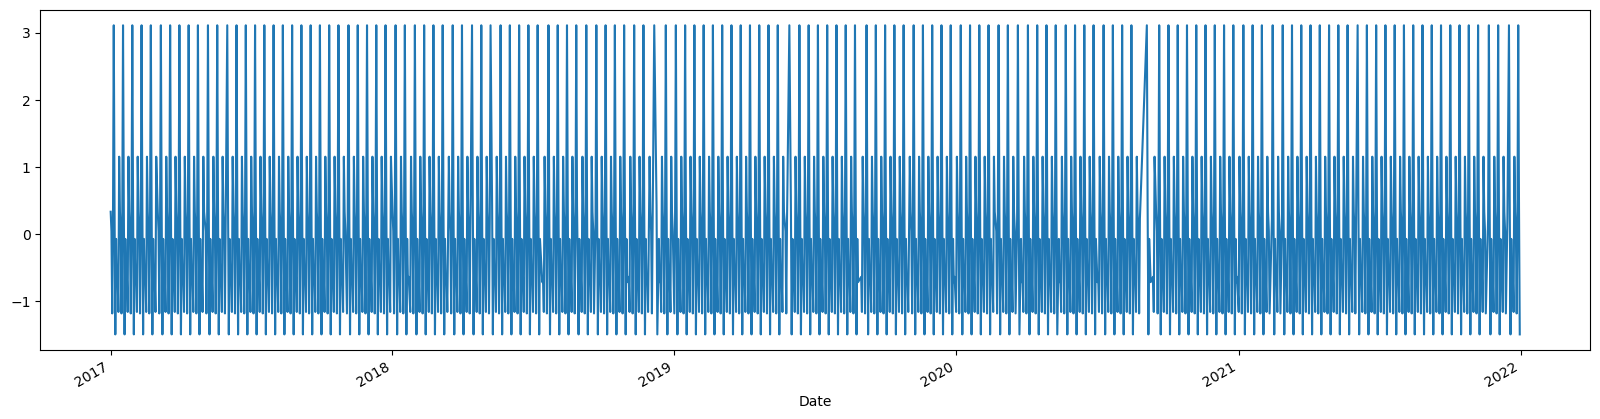

In [13]:
### seasonal
decomposition.seasonal.plot(figsize=(20,5))

<AxesSubplot: xlabel='Date'>

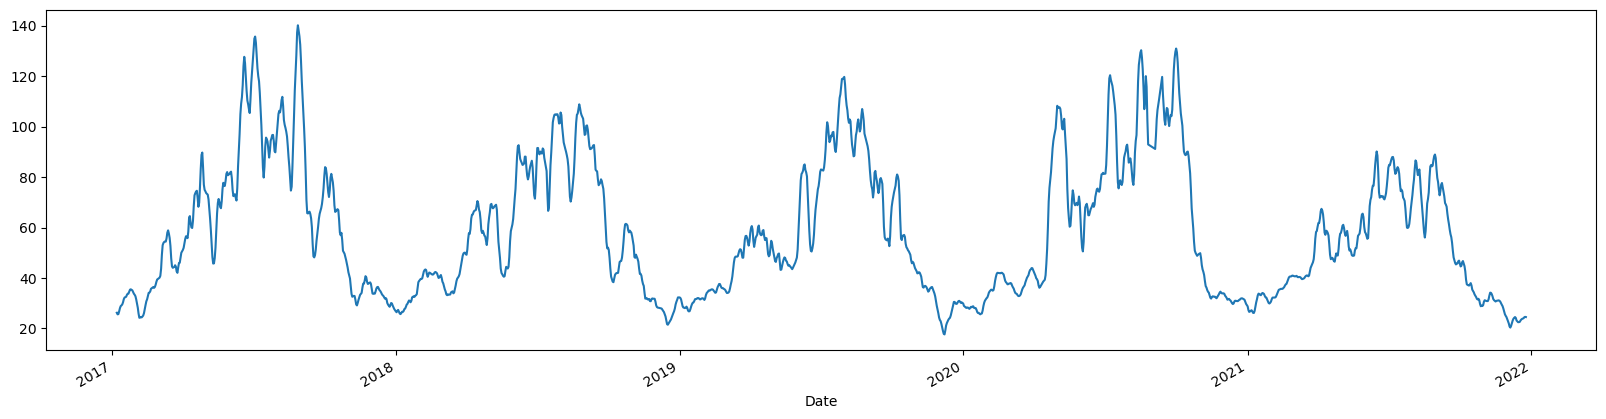

In [14]:
# trend Plot
decomposition.trend.plot(figsize=(20,5))

<AxesSubplot: xlabel='Date'>

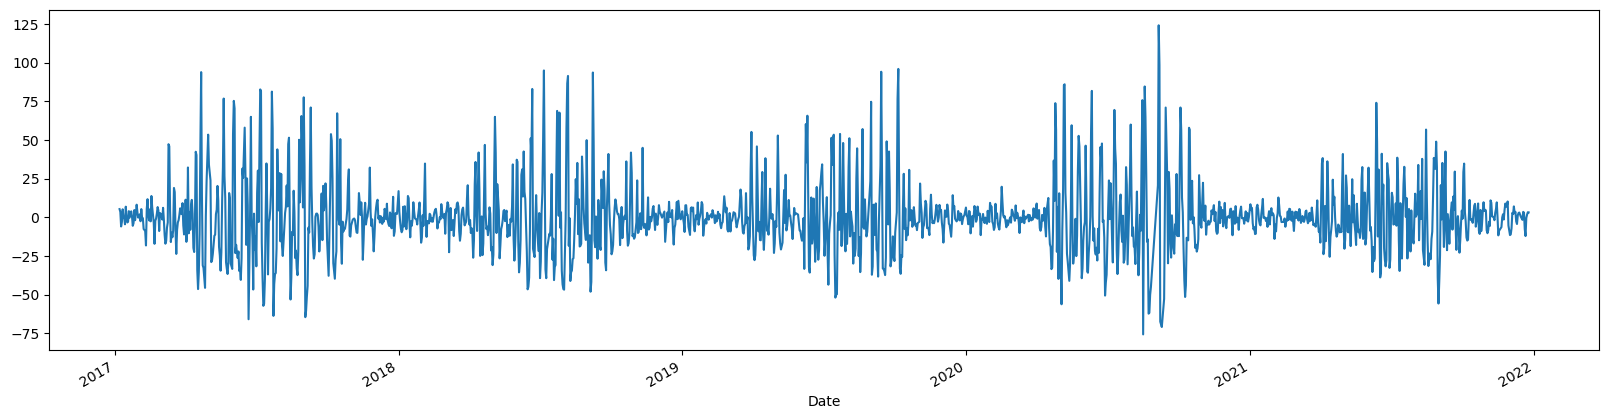

In [15]:
# trend Resid
decomposition.resid.plot(figsize=(20,5))

In [21]:
train

,UNITS,DAILY_AQI_VALUE,Site Name,AQS_PARAMETER_DESC,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
Date,,,,,,,
2017-01-01,ppm,34.0,Azusa,Ozone,Los Angeles,34.1365,-117.92391
2017-01-02,ppm,35.0,Azusa,Ozone,Los Angeles,34.1365,-117.92391
2017-01-03,ppm,24.0,Azusa,Ozone,Los Angeles,34.1365,-117.92391
2017-01-04,ppm,19.0,Azusa,Ozone,Los Angeles,34.1365,-117.92391
2017-01-05,ppm,14.0,Azusa,Ozone,Los Angeles,34.1365,-117.92391
...,...,...,...,...,...,...,...
2021-06-28,ppm,101.0,Azusa,Ozone,Los Angeles,34.1365,-117.92391
2021-06-29,ppm,44.0,Azusa,Ozone,Los Angeles,34.1365,-117.92391
2021-06-30,ppm,51.0,Azusa,Ozone,Los Angeles,34.1365,-117.92391


In [16]:
# Splitting Dataset into train & test se
train = Azusa_DT.iloc[:int(Azusa_DT.shape[0]*0.9)]
test = Azusa_DT.iloc[int(Azusa_DT.shape[0]*0.9):]

print(Azusa_DT.shape[0])
print(train.shape,test.shape)

1771
(1593, 7) (178, 7)


In [22]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(
    train['DAILY_AQI_VALUE'],
    order=(2, 0, 2)
).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        DAILY_AQI_VALUE   No. Observations:                 1593
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -7148.215
Date:                Sun, 05 Feb 2023   AIC                          14308.430
Time:                        21:30:24   BIC                          14340.670
Sample:                             0   HQIC                         14320.404
                               - 1593                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         58.9840     13.293      4.437      0.000      32.931      85.037
ar.L1          1.3751      0.036     38.538      0.000       1.305       1.445
ar.L2         -0.3815      0.035    -11.030      0.000      -0.449      -0.314
ma.L1         -0.6038      0.034    -17.764      0.000      -0.670      -0.537
ma.L2         -0.2916      0.024    -12.355      0.000      -0.338      -0.245
sigma2       462.0407     10.935     42.255      0.000     440.609     483.472
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1031.41
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.67
Prob(H) (two-sided):                  0.83   Kurtosis:                         6.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot: xlabel='Date'>

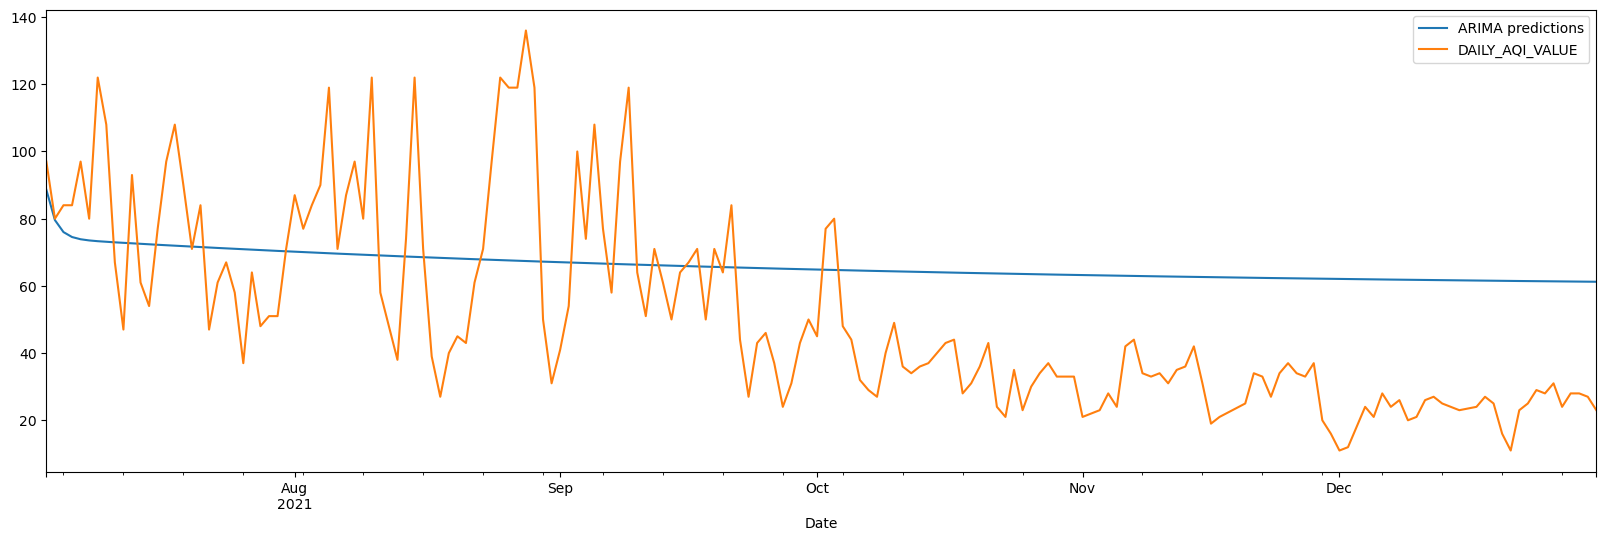

In [24]:
index_future_dates = pd.date_range(start=test.index[0],end=test.index[-1])
start = len(train)
end = len(train)+len(index_future_dates)-1

pred = model.predict(
    start=start, 
    end=end,
    typ='levels'
).rename('ARIMA predictions')
pred.index=index_future_dates

plt.figure(figsize=(20,6))
pred.plot(legend=True)
test['DAILY_AQI_VALUE'].plot(legend=True)

### Root Mean Squared Error 
Root Mean Squared Error (RMSE) is a measure of the difference between predicted values and observed values. It is commonly used in the field of machine learning and statistics to evaluate the performance of a model.

The RMSE is calculated as the square root of the mean squared error (MSE), which is the average of the squared differences between the predicted values and the actual values. The MSE is calculated by taking the sum of the squared differences between the predicted values and the actual values, and dividing by the number of observations. The RMSE is typically expressed in the same units as the original data, making it easier to interpret.

Here is the formula for RMSE:

RMSE = sqrt(mean((predicted - observed)^2))

The RMSE is a measure of the difference between the predicted values and the observed values. A smaller RMSE indicates a better fit of the model to the data

In [19]:
from sklearn.metrics import mean_squared_error
var = len(pred)-len(test)
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(np.array(pred[var:]), np.array(test['DAILY_AQI_VALUE']))))

Root Mean Squared Error: 22.036915689759702


### Future Predication 2023 

Predicting the Future Forcasting For January 2023

<AxesSubplot:>

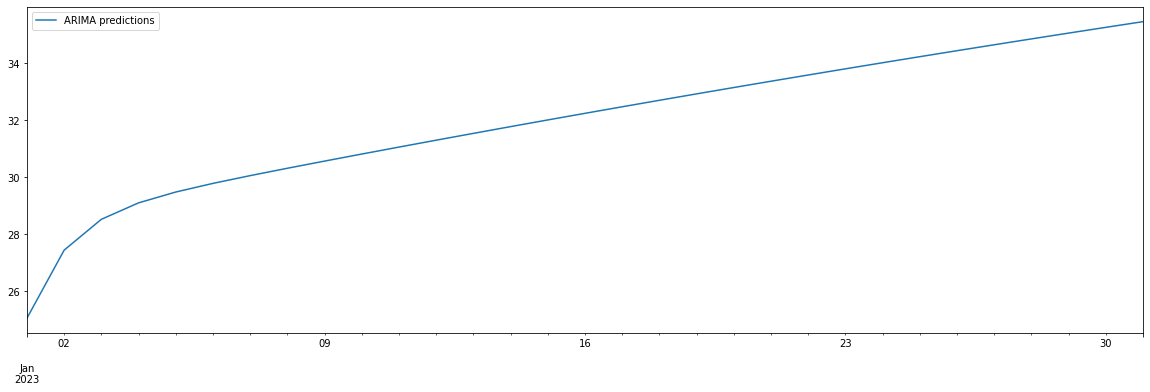

In [20]:
index_future_dates = pd.date_range(start='2023-01-01',end='2023-01-31')
start = len(train)+len(test)
end = start+len(index_future_dates)-1

pred = model.predict(
    start=start, 
    end=end,
    typ='levels'
).rename('ARIMA predictions')
pred.index=index_future_dates

plt.figure(figsize=(20,6))
pred.plot(legend=True)

--------------------------------------------------------------------------------------------------------------------------

## XGB Regressor 

In [21]:
Dataset = pd.read_csv('/kaggle/input/air-pollution-dataset/Attachment_1671655114.csv', parse_dates=True)
Dataset = Dataset[['Date', 'UNITS', 'DAILY_AQI_VALUE', 'Site Name', 'AQS_PARAMETER_DESC','COUNTY', 'SITE_LATITUDE', 'SITE_LONGITUDE']]


# Appling Preprocessing to Split Date into Year, Month, Day in numeric fro model training
Dataset['Year'] = pd.to_datetime(Dataset['Date']).apply(lambda time: time.year)
Dataset['Month'] = pd.to_datetime(Dataset['Date']).apply(lambda time: time.month)
Dataset['Day'] = pd.to_datetime(Dataset['Date']).apply(lambda time: time.day)

Dataset.head(3)

,Date,UNITS,DAILY_AQI_VALUE,Site Name,AQS_PARAMETER_DESC,COUNTY,SITE_LATITUDE,SITE_LONGITUDE,Year,Month,Day
0,1/1/2017,ppm,6.0,Azusa,Carbon monoxide,Los Angeles,34.1365,-117.92391,2017,1,1
1,1/2/2017,ppm,5.0,Azusa,Carbon monoxide,Los Angeles,34.1365,-117.92391,2017,1,2
2,1/3/2017,ppm,5.0,Azusa,Carbon monoxide,Los Angeles,34.1365,-117.92391,2017,1,3


In [22]:
Dataset['Site Name'].unique()

array(['Azusa', 'Glendora', 'West Los Angeles',
       'Los Angeles-North Main Street', 'Reseda', 'Compton',
       'Pico Rivera #2', 'Pomona', 'Pasadena', 'Long Beach (Hudson)',
       'LAX Hastings', 'Santa Clarita', 'Lancaster-Division Street',
       'Long Beach (South)', 'Long Beach (North)',
       'Long Beach-Route 710 Near Road', 'Lebec',
       'North Hollywood (NOHO)', 'Signal Hill (LBSH)', 'San Francisco',
       'Oakland', 'Oakland West', 'Laney College',
       'Berkeley- Aquatic Park', 'Pleasanton - Owens Ct', 'Livermore',
       'Hayward', 'Patterson Pass'], dtype=object)

In [23]:
Dataset.AQS_PARAMETER_DESC.unique()

array(['Carbon monoxide', 'PM10 Total 0-10um STP',
       'PM2.5 - Local Conditions',
       'Acceptable PM2.5 AQI & Speciation Mass', 'Ozone'], dtype=object)

In [24]:
Site_Name = 'Azusa'  # You can Change Site Name List Above to Predict the Future Forcasting 

In [25]:
Azusa_DT = Dataset[Dataset['Site Name']==Site_Name]
Azusa_DT = Azusa_DT[Azusa_DT['AQS_PARAMETER_DESC']=='PM2.5 - Local Conditions']
Azusa_DT.head(1)

,Date,UNITS,DAILY_AQI_VALUE,Site Name,AQS_PARAMETER_DESC,COUNTY,SITE_LATITUDE,SITE_LONGITUDE,Year,Month,Day
28579,1/1/2017,ug/m3 LC,35.0,Azusa,PM2.5 - Local Conditions,Los Angeles,34.1365,-117.92391,2017,1,1


In [26]:
Azusa_DT.columns

Index(['Date', 'UNITS', 'DAILY_AQI_VALUE', 'Site Name', 'AQS_PARAMETER_DESC',
       'COUNTY', 'SITE_LATITUDE', 'SITE_LONGITUDE', 'Year', 'Month', 'Day'],
      dtype='object')

In [27]:
Azusa_DT = Azusa_DT[['Date', 'DAILY_AQI_VALUE', 'SITE_LATITUDE', 'SITE_LONGITUDE', 'Year', 'Month', 'Day']]
Azusa_DT = Azusa_DT.reset_index()
Azusa_DT.head()

,index,Date,DAILY_AQI_VALUE,SITE_LATITUDE,SITE_LONGITUDE,Year,Month,Day
0,28579,1/1/2017,35.0,34.1365,-117.92391,2017,1,1
1,28580,1/4/2017,35.0,34.1365,-117.92391,2017,1,4
2,28581,1/7/2017,15.0,34.1365,-117.92391,2017,1,7
3,28582,1/10/2017,21.0,34.1365,-117.92391,2017,1,10
4,28583,1/13/2017,19.0,34.1365,-117.92391,2017,1,13


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    Azusa_DT[['Date', 'SITE_LATITUDE', 'SITE_LONGITUDE', 'Year', 'Month', 'Day']], 
    Azusa_DT['DAILY_AQI_VALUE'], 
    test_size=0.1
)

In [29]:
import xgboost as xgb
import multiprocessing

model = xgb.XGBRegressor(
    n_jobs=multiprocessing.cpu_count() // 2,
    learning_rate=0.1, 
    max_depth=12, 
    n_estimators=100
).fit(
    X_train[['SITE_LATITUDE', 'SITE_LONGITUDE', 'Year', 'Month', 'Day']],
    y_train
)
model

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=2,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [30]:
pred_y = model.predict(X_test[['SITE_LATITUDE', 'SITE_LONGITUDE', 'Year', 'Month', 'Day']])

In [31]:
from sklearn.metrics import mean_squared_error
var = len(pred)-len(test)
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(pred_y, y_test)))

Root Mean Squared Error: 20.303475232914113


<AxesSubplot:xlabel='Date'>

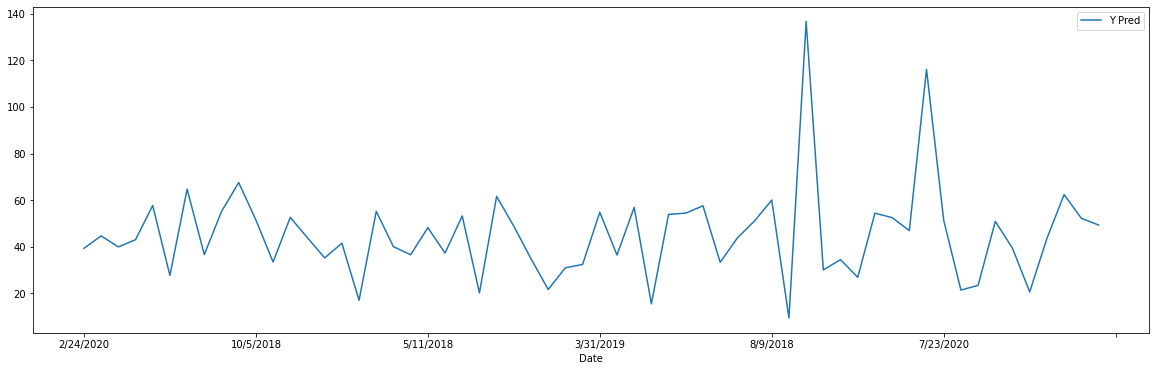

In [32]:
Graph = pd.DataFrame(pred_y, columns=['Y Pred'])
Graph.index = X_test['Date']

Graph.plot(figsize=(20, 6))

<AxesSubplot:xlabel='Date'>

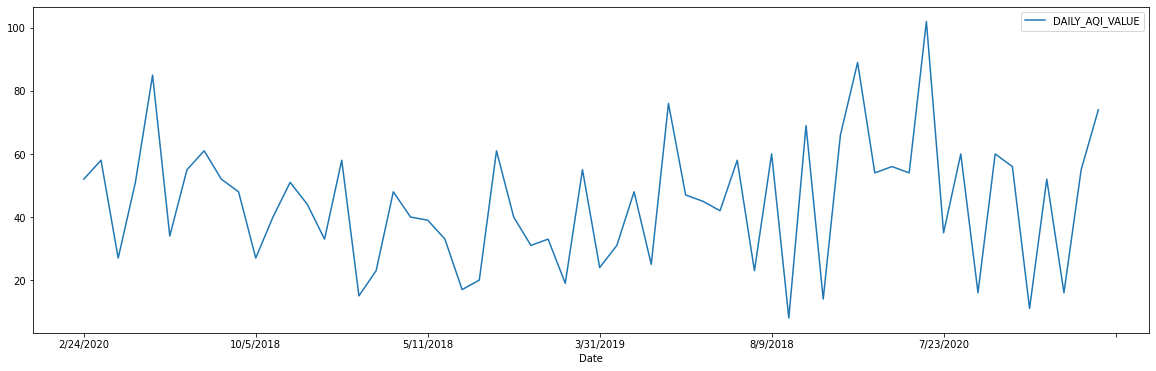

In [33]:
Graph2 = pd.DataFrame(y_test) #"", columns=['Y Ac'])
Graph2.index = X_test['Date']

Graph2.plot(figsize=(20, 6))

### Future Prediction

In [34]:
Dataset = pd.read_csv('/kaggle/input/air-pollution-dataset/Attachment_1671655114.csv', parse_dates=True)
Dataset.columns

Index(['Date', 'Source', 'Site ID', 'POC', 'Daily Max 8-hour CO Concentration',
       'UNITS', 'DAILY_AQI_VALUE', 'Site Name', 'DAILY_OBS_COUNT',
       'PERCENT_COMPLETE', 'AQS_PARAMETER_CODE', 'AQS_PARAMETER_DESC',
       'CBSA_CODE', 'CBSA_NAME', 'STATE_CODE', 'STATE', 'COUNTY_CODE',
       'COUNTY', 'SITE_LATITUDE', 'SITE_LONGITUDE'],
      dtype='object')

In [35]:
temp = Dataset[Dataset['Site Name']==Site_Name][['SITE_LATITUDE','SITE_LONGITUDE']]
SITE_LATITUDE = temp['SITE_LATITUDE'][0]
SITE_LONGITUDE = temp['SITE_LONGITUDE'][0]

SITE_LATITUDE, SITE_LONGITUDE

(34.1365, -117.92391)

In [36]:
Jan2023 = pd.DataFrame()
Jan2023['Date'] = pd.date_range(start='2023-01-01',end='2023-01-31')
Jan2023['SITE_LATITUDE'] = SITE_LATITUDE
Jan2023['SITE_LONGITUDE'] = SITE_LONGITUDE

Jan2023['Year'] = pd.to_datetime(Jan2023['Date']).apply(lambda time: time.year)
Jan2023['Month'] = pd.to_datetime(Jan2023['Date']).apply(lambda time: time.month)
Jan2023['Day'] = pd.to_datetime(Jan2023['Date']).apply(lambda time: time.day)

Jan2023.head()

,Date,SITE_LATITUDE,SITE_LONGITUDE,Year,Month,Day
0,2023-01-01,34.1365,-117.92391,2023,1,1
1,2023-01-02,34.1365,-117.92391,2023,1,2
2,2023-01-03,34.1365,-117.92391,2023,1,3
3,2023-01-04,34.1365,-117.92391,2023,1,4
4,2023-01-05,34.1365,-117.92391,2023,1,5


In [37]:
pred_y = model.predict(Jan2023[['SITE_LATITUDE', 'SITE_LONGITUDE', 'Year', 'Month', 'Day']])

<AxesSubplot:xlabel='Date'>

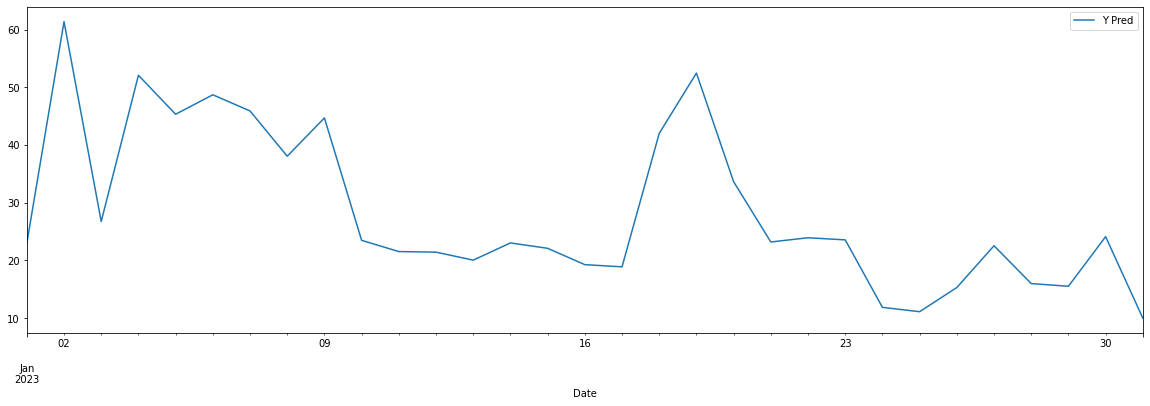

In [38]:
Graph = pd.DataFrame(pred_y, columns=['Y Pred'])
Graph.index = Jan2023['Date']

Graph.plot(figsize=(20, 6))